# Six degrees of seperation


Tasks from: https://cac.cornell.edu/myers/teaching/ComputationalMethods/ComputerExercises/SmallWorld/SmallWorld.html:

**Import modules**

In [1]:
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import time

**Define classes**

In [2]:
class connection: #defines one connection from one node to another
    def __init__(self,node1,node2,typ):
        self.node1 = node1
        self.node2 = node2
        self.nodes = [node1,node2]
        self.typ = typ

In [3]:
class node: #defines one node; including a list of all connections
    def __init__(self, number):
        self.number = number
        self.connections = []

    def exist_connection_to(self, node2): #return true, if the connection node-node2 allready exists
        for c in self.connections:
            if c.node2 == node2:
                return True
        
        return False



In [4]:
class network: #defines the network with list of all nodes
    #def __init__(self, L, Z, p):
    #    self.L = L
    #    self.Z = Z
    #    self.p = p
    #    self.node_list = self.construct_network(L,Z,p)
        
    def __init__(self,parameters,real = False):
        if real:
            self.path = parameters[0]
            self.node_list = self.construct_real_network(self.path)
            self.L = len(self.node_list)
        else:
            self.L = parameters[0]
            self.Z = parameters[1]
            self.p = parameters[2]
            self.node_list = self.construct_network(self.L,self.Z,self.p)
               
    @classmethod
    def from_algorithm(cls,L,Z,p):
        return cls([L,Z,p],real = False)
            
    @classmethod
    def from_real_world(cls,path):
        return cls([path],real = True)
            
               
    def construct_network(self,L,Z,p):
      #there are L nodes in the network
      #each node have Z connections to nearest neighbours
      #there are p*L*Z/2 random edges to other nodes
        node_list = []

        #create L nodes
        for i in range(L):
            node_list.append(node(i))

        #create edges to nearest neighbours
        for i in range(L):
            for j in range(L):
                if i != j:
                    if abs(node_list[i].number - node_list[j].number) <= Z/2: #connection without reaching a boundary
                        node_list[i].connections.append(connection(i,j,"neighbour"))
                    elif abs(node_list[i].number - node_list[j].number + L) <= Z/2: #periodic boundaries, upper boundary
                        node_list[i].connections.append(connection(i,j,"neighbour"))
                    elif abs(node_list[i].number - node_list[j].number - L) <= Z/2: #periodic boundaries, lower boundary
                        node_list[i].connections.append(connection(i,j,"neighbour"))


        #create random connection between nodes
        N_random_connections = int(p * L * Z/2)
        print("create",N_random_connections,"connections")

        i = 0
        while i < N_random_connections:
          node1 = random.randint(0,L-1)
          node2 = random.randint(0,L-1)
          if not(node_list[node1].exist_connection_to(node2)):
            if not(node_list[node2].exist_connection_to(node1)):
              node_list[node1].connections.append(connection(node1,node2,"random"))
              node_list[node2].connections.append(connection(node2,node1,"random"))
              i = i + 1

        return node_list
    
    
    def construct_real_network(self,path,max_number_nodes=50):
        #construct a real world network which have the properties as described here: https://www.weizmann.ac.il/mcb/UriAlon/download/collection-complex-networks
        node_list = []
        
        
        #read csv into dataframe
        df = pd.read_csv(path,
                 names=["source","target","unknown"], sep = " ")
        
        
        #create all nodes (but only to the max_number_nodes for performance reasons)
        N = min([max(df.iloc[:,0]),max_number_nodes])
        for i in range(N):
            node_list.append(node(i))
            
            
        #create edges to nodes with information from df
        for i in range(len(df)):
            source_node = df.iat[i,0]-1
            target_node = df.iat[i,1]-1
            
            if source_node >= N or target_node >= N:#for performance reasons: ignore nodes higher then max_number_nodes
                continue 
    
            node_list[source_node].connections.append(connection(source_node,target_node,""))
            node_list[target_node].connections.append(connection(target_node,source_node,""))
        
        return node_list

    
    def draw_network(self,draw_text = True):
      plt.figure(figsize=(10,10))

      #draw nodes of the network
      for n in self.node_list:
        x1 = math.cos((n.number/self.L)*2*math.pi) * 100
        y1 = math.sin((n.number/self.L)*2*math.pi) * 100
        plt.plot(x1, y1, 'bo')
        if draw_text:
          plt.annotate(str(n.number), (x1, y1))

        #draw connections of one node; use different colours for different nodes
        for conn in n.connections:
          x2 = math.cos((conn.node2/self.L)*2*math.pi) * 100
          y2 = math.sin((conn.node2/self.L)*2*math.pi) * 100
          if conn.typ == "neighbour":
            plt.plot((x1, x2), (y1, y2), 'r')
          elif conn.typ == "random":
            plt.plot((x1, x2), (y1, y2), 'g--')
          else:
            plt.plot((x1, x2), (y1, y2), 'r--')

      plt.show()

**Example: Create a random network and draw it**

L nodes in a small world network are arranged around a circle

Z short edges connecting it to its nearest neighbors

p*L*Z/2 shortcuts added to the network,

create 2 connections


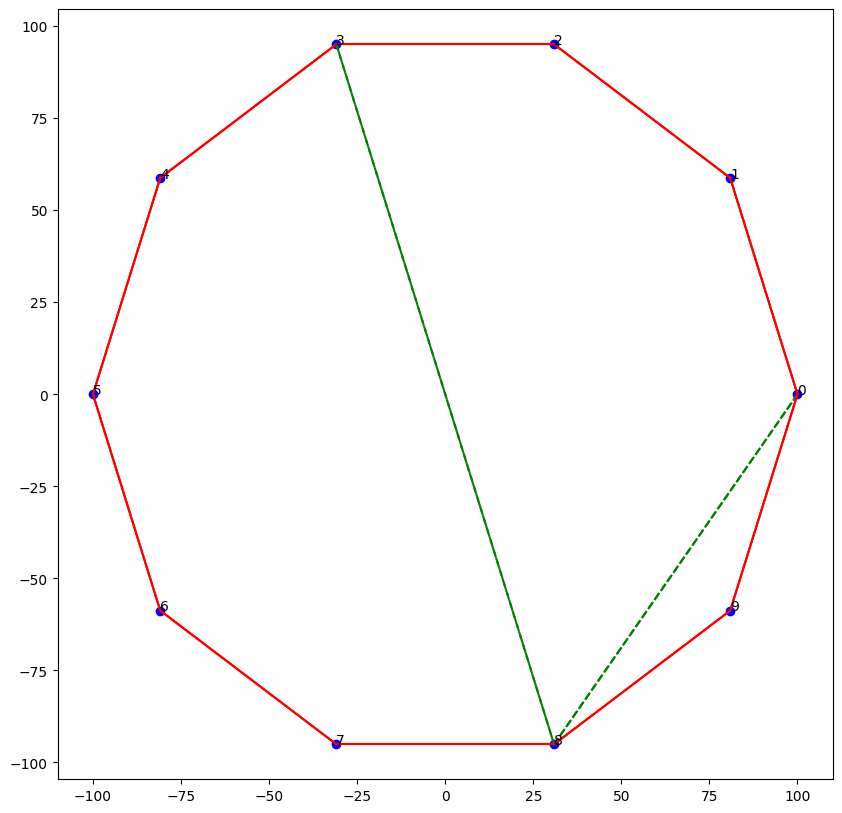

In [5]:
L = 10
Z = 2
p = 0.2

ntwrk = network.from_algorithm(L,Z,p)
ntwrk.draw_network(draw_text = True)

In [6]:


print(int(p * L * Z/2))
print(p * L * Z/2/(L*Z/2))


2
0.2


**Calculate path lengths**

In [7]:
def FindPathLengthsFromNode(network,i_node1,show_time=False): #returns for each node in the graph the shortest distance seen from node1 (in a dataframe)
  starttime = time.time()

  #create dataframe, which will contain all informations of paths
  path_length_df = pd.DataFrame()


  #lists to fill the dataframe
  N = len(network.node_list)
  path_length_df["node1"] = np.full(N,i_node1)
  path_length_df["node2"] = np.arange(N)
  path_length_df["path_length"] = np.full(N,float('nan'))
  path_length_df["shortest_path"] = np.full(N,['nan'])


  #lists needed for breadth first algorithm
  queue = [i_node1]
  paths = [[i_node1]]
  nodes_viewed = []
  while len(nodes_viewed) != N:
    #if queue is empty perhabs the network is not fully connected
    if len(queue) == 0:
        break
    
    #get first entry of queue
    actual_node = queue.pop(0) #dequeue first item and set it to the actual viewed node
    actual_path = paths.pop(0)

    #if a new node was found
    if np.isnan(path_length_df.at[actual_node,"path_length"]):
      path_length_df.at[actual_node,"path_length"] = len(actual_path)-1
      path_length_df.at[actual_node,"shortest_path"] = actual_path
      #path_length_df.at[actual_node,"shortest_path"] = 0

      #mark node as viewed
      nodes_viewed.append(actual_node)

    #set new queue and new actual path
    for c in network.node_list[actual_node].connections: #for each connected node
      if not(c.node2 in nodes_viewed): #is the node allready viewed?

        #fill queue
        queue.append(c.node2)

        #update possible paths
        temp_p = copy.deepcopy(actual_path)
        temp_p.append(c.node2)
        paths.append(temp_p)


  if show_time:
    print("ellapsed_time in sec:",time.time()-starttime)

  return path_length_df


In [8]:
FindPathLengthsFromNode(ntwrk,0,show_time=True)

ellapsed_time in sec: 0.02433609962463379


node1  node2  path_length    shortest_path
0      0      0          0.0              [0]
1      0      1          1.0           [0, 1]
2      0      2          2.0        [0, 1, 2]
3      0      3          2.0        [0, 8, 3]
4      0      4          3.0     [0, 8, 3, 4]
5      0      5          4.0  [0, 8, 7, 6, 5]
6      0      6          3.0     [0, 8, 7, 6]
7      0      7          2.0        [0, 8, 7]
8      0      8          1.0           [0, 8]
9      0      9          1.0           [0, 9]

**Find all path lengths**

In [9]:
def FindAllPathLengths(ntwrk):
    path_length_list = []

    for i in tqdm (range(len(ntwrk.node_list)), desc="Compute"):
        path_length_df = FindPathLengthsFromNode(ntwrk,i)
        for j in range(len(path_length_df)):
            if path_length_df.loc[j,"node2"] > path_length_df.loc[j,"node1"]:
                path_length_list.append(path_length_df.loc[j,"path_length"])

    return path_length_list

In [10]:
print(FindAllPathLengths(ntwrk))

Compute: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 156.84it/s]

[1.0, 2.0, 2.0, 3.0, 4.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 4.0, 4.0, 3.0, 2.0, 2.0, 1.0, 2.0, 3.0, 4.0, 3.0, 2.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 2.0, 3.0, 1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0]


Check your function by testing that
the histogram of path lengths at p = 0
is constant for 0 < l < L/Z, as
advertised.

In [11]:
p = 0
Z = 2
L = 100

ntwrk_test0 = network.from_algorithm(L,Z,p)

create 0 connections


In [12]:
list_test0 = FindAllPathLengths(ntwrk_test0)

Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.64it/s]


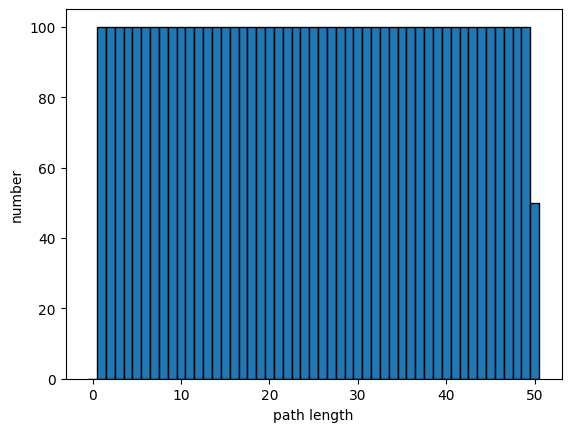

In [13]:
#hist_test0 = plt.hist(list_test0,bins =10, range=[0,100/2],align='mid',ec="k")

bin_edges = np.arange( - 0.5, max(list_test0) + 1.5, 1)  # Bin edges centered around integers
plt.hist(list_test0, bins=bin_edges, edgecolor='black')

plt.xlabel("path length")
plt.ylabel("number")

plt.show()

Generate graphs at L =
1, 000 and Z = 2 for p = 0.02 and
p = 0.2; display the circle graphs and
plot the histogram of path lengths.
Zoom in on the histogram; how much
does it change with p? What value of p
would you need to get “six degrees of
separation”?

In [14]:
ntwrk_test1 = network.from_algorithm(1000,2,0.02)
ntwrk_test2 = network.from_algorithm(1000,2,0.2)

create 20 connections
create 200 connections


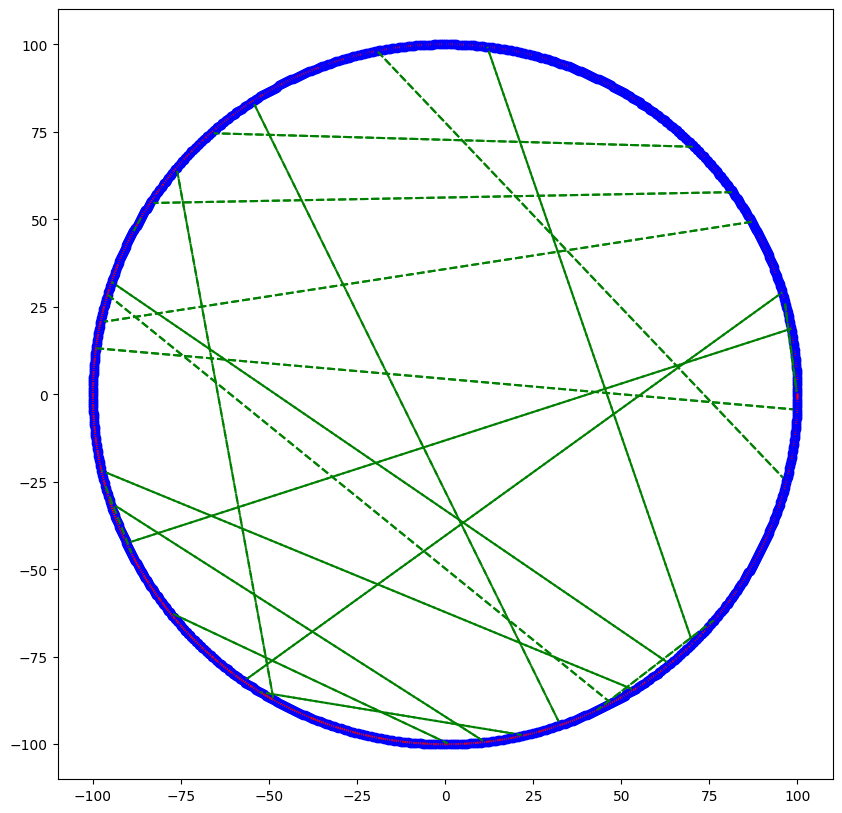

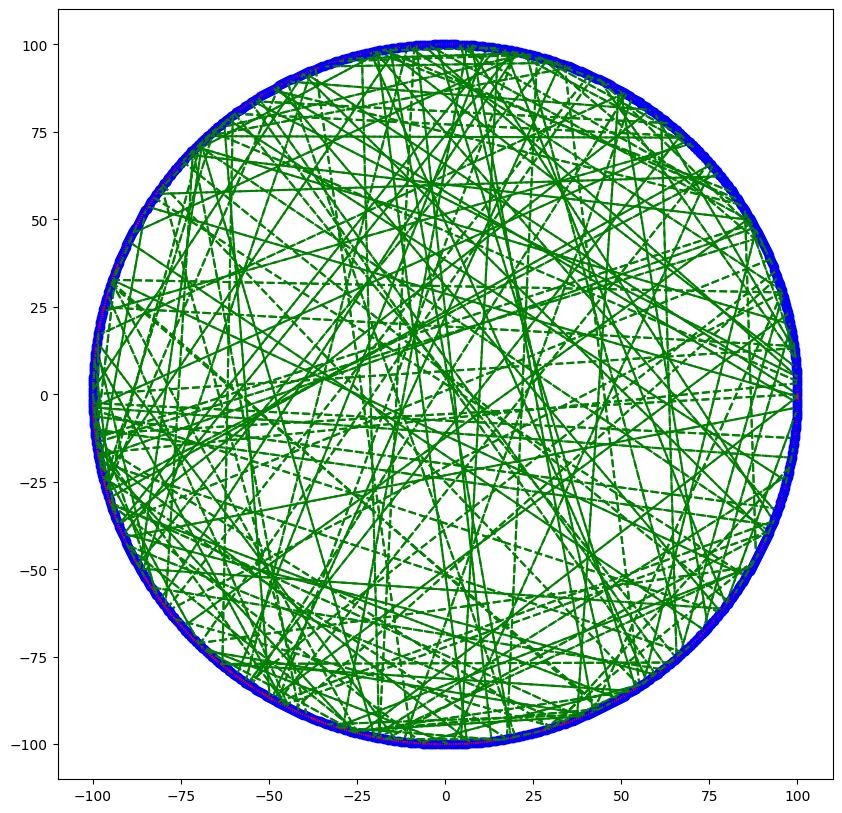

In [15]:
ntwrk_test1.draw_network(draw_text = False)
ntwrk_test2.draw_network(draw_text = False)

In [16]:
list_test1 = FindAllPathLengths(ntwrk_test1)
list_test2 = FindAllPathLengths(ntwrk_test2)

Compute: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:50<00:00,  5.87it/s]


Text(0, 0.5, 'number')

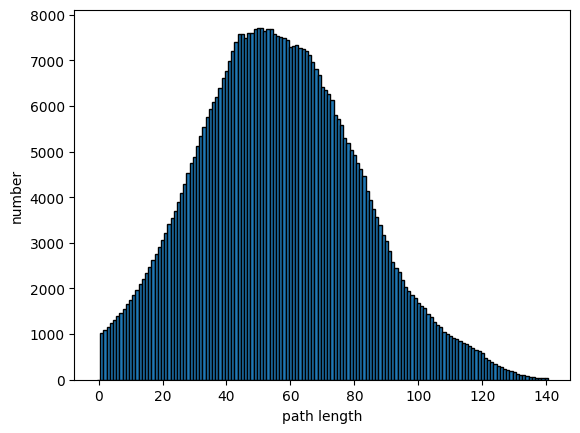

In [17]:
bin_edges = np.arange( - 0.5, max(list_test1) + 1.5, 1)  # Bin edges centered around integers
hist_test1 = plt.hist(list_test1, bins=bin_edges, edgecolor='black')

plt.xlabel("path length")
plt.ylabel("number")

Text(0, 0.5, 'number')

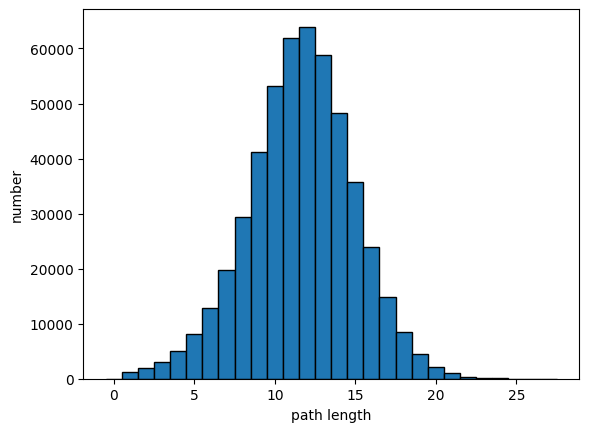

In [18]:
bin_edges = np.arange( - 0.5, max(list_test2) + 1.5, 1)  # Bin edges centered around integers
hist_test2 = plt.hist(list_test2, bins=bin_edges, edgecolor='black')

plt.xlabel("path length")
plt.ylabel("number")

create 800 connections


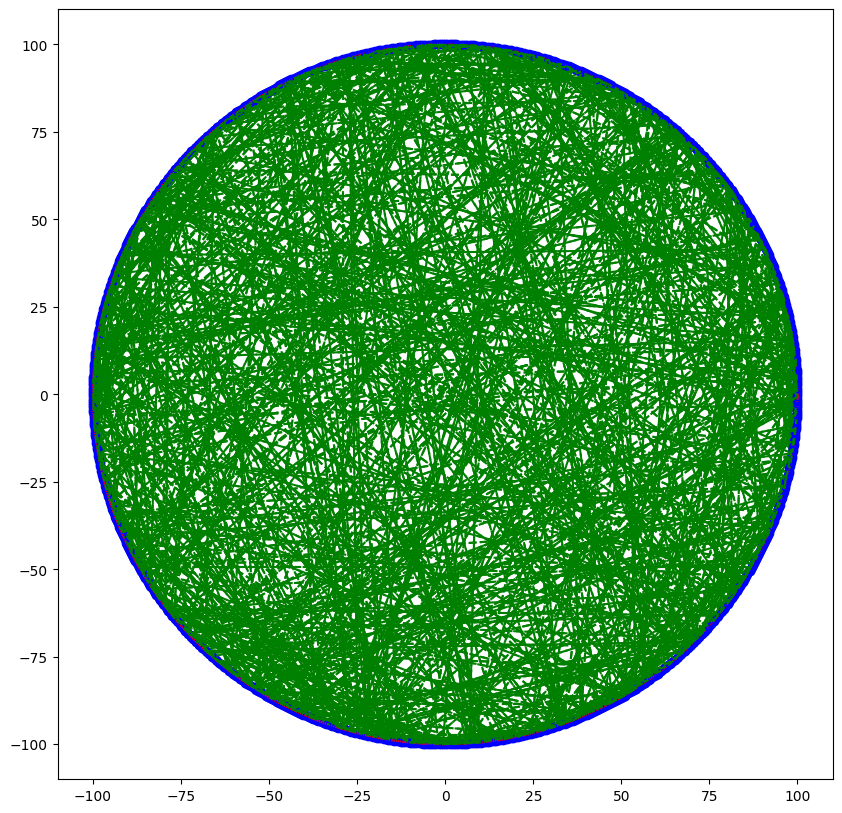

In [19]:
ntwrk_test3 = network.from_algorithm(1000,2,0.8)
ntwrk_test3.draw_network(draw_text = False)

In [20]:
list_test3 = FindAllPathLengths(ntwrk_test3)

Compute: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.11it/s]


Text(0, 0.5, 'number')

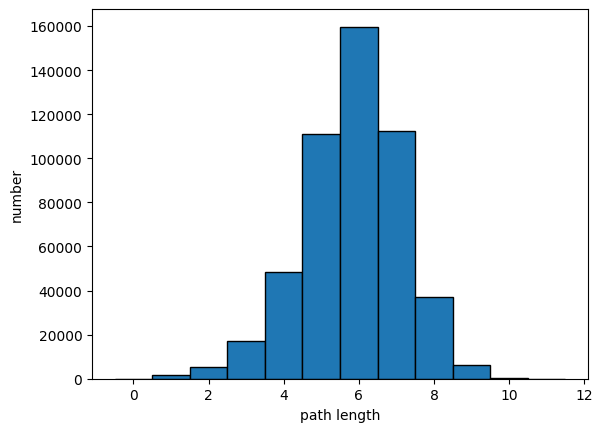

In [21]:
bin_edges = np.arange( - 0.5, max(list_test3) + 1.5, 1)  # Bin edges centered around integers
hist_test3 = plt.hist(list_test3, bins=bin_edges, edgecolor='black')

plt.xlabel("path length")
plt.ylabel("number")

create 2000 connections


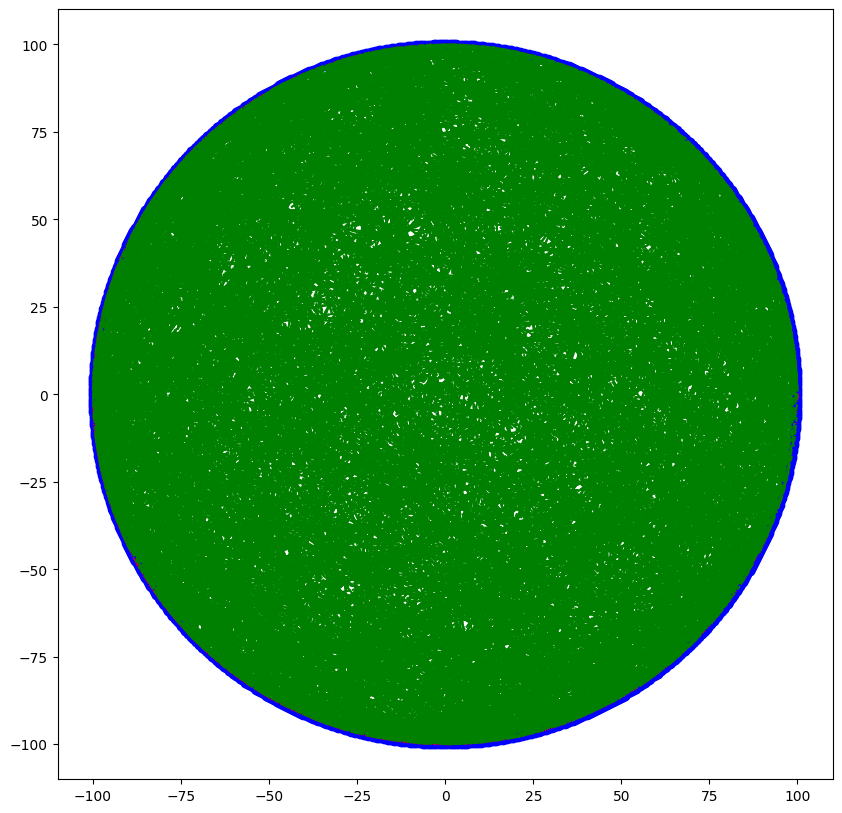

In [22]:
ntwrk_test4 = network.from_algorithm(1000,2,2)
ntwrk_test4.draw_network(draw_text = False)

In [23]:
list_test4 = FindAllPathLengths(ntwrk_test4)

Compute: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [07:41<00:00,  2.16it/s]


Text(0, 0.5, 'number')

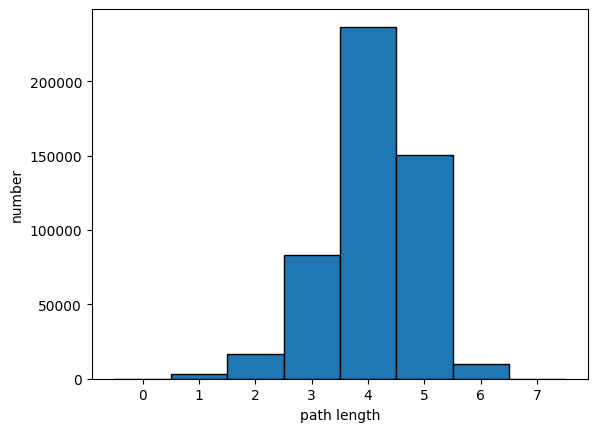

In [24]:
bin_edges = np.arange( - 0.5, max(list_test4) + 1.5, 1)  # Bin edges centered around integers
hist_test4 = plt.hist(list_test4, bins=bin_edges, edgecolor='black')

plt.xlabel("path length")
plt.ylabel("number")

**Find average path length**

FindAveragePathLength(graph), which computes the mean
hli over all pairs of nodes.

In [25]:
def FindAveragePathLength(ntwrk):
    lst = FindAllPathLengths(ntwrk)
    lst = [item for item in lst if not(math.isnan(item)) == True]

    return np.mean(lst)

Compute l for Z = 2, L = 100, and
p = 0.1 a few times; your answer should be around l = 10

In [26]:
Z = 2
L = 100
p = 0.1

av_path_length = []

for i in range(100):
    av_path_length.append(FindAveragePathLength(network.from_algorithm(L,Z,p)))

create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.25it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.47it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.06it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.55it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.78it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.03it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.20it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.20it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.30it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.66it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.59it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.06it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.02it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.62it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.27it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.43it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.95it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.80it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.75it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.42it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.38it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.29it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.88it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.15it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.68it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.99it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.29it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.10it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.57it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.59it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.22it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.38it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.81it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.05it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.54it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.75it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.85it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.33it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.26it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.58it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.95it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.01it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.23it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.82it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.29it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 76.74it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.98it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.26it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.40it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.04it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.95it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.56it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.47it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.26it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.48it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.39it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.68it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.71it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.03it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.69it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.98it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.68it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.05it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.28it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.80it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.74it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.24it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.75it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.15it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.26it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.74it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.30it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.16it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.82it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.81it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.52it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.68it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.62it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.04it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.92it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.34it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 50.00it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.05it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.32it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.42it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.34it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.65it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.88it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.07it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.89it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.89it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.18it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.49it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.89it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.63it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.85it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.95it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.52it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.48it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.90it/s]


(array([10., 27., 15., 22., 12.,  7.,  3.,  2.,  0.,  2.]),
 array([ 8.56343434,  8.97355556,  9.38367677,  9.79379798, 10.20391919,
        10.6140404 , 11.02416162, 11.43428283, 11.84440404, 12.25452525,
        12.66464646]),
 <BarContainer object of 10 artists>)

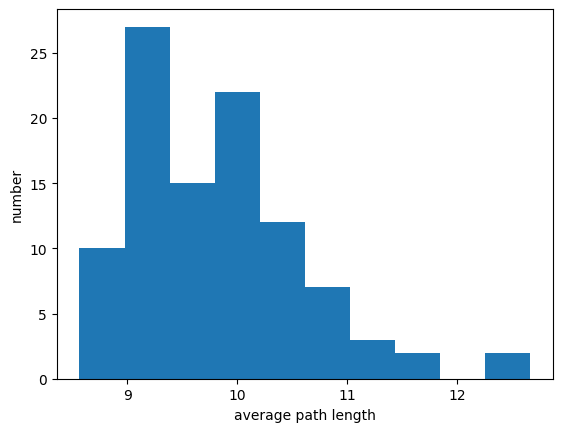

In [27]:
plt.xlabel("average path length")
plt.ylabel("number")
plt.hist(av_path_length)


Plot the average path length between nodes l(p) divided by l(p =
0) for Z = 2, L = 50, with p on a semi-log plot from p = 0.001 to
p = 1.6

In [28]:
p_list = []
l_list = []

for p in np.logspace(-3,1,num=20):
    print(p)
    p_list.append(p)
    l_list.append(FindAveragePathLength(network.from_algorithm(50,2,p)))

0.001
create 0 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 108.24it/s]


0.001623776739188721
create 0 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 103.68it/s]


0.0026366508987303583
create 0 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 103.71it/s]


0.004281332398719396
create 0 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 91.76it/s]


0.0069519279617756054
create 0 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.32it/s]


0.011288378916846888
create 0 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 101.06it/s]


0.018329807108324356
create 0 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.96it/s]


0.029763514416313176
create 1 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.15it/s]


0.04832930238571752
create 2 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.52it/s]


0.07847599703514611
create 3 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.11it/s]


0.12742749857031335
create 6 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 110.68it/s]


0.20691380811147903
create 10 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 131.80it/s]


0.3359818286283781
create 16 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 138.48it/s]


0.5455594781168515
create 27 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 143.78it/s]


0.8858667904100823
create 44 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 126.83it/s]


1.438449888287663
create 71 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 131.75it/s]


2.3357214690901213
create 116 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.57it/s]


3.792690190732246
create 189 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 102.97it/s]


6.158482110660261
create 307 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 108.01it/s]


10.0
create 500 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 96.50it/s]


In [29]:
FindAveragePathLength(network.from_algorithm(50,2,p))

create 500 connections


Compute: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 92.43it/s]


1.5559183673469388

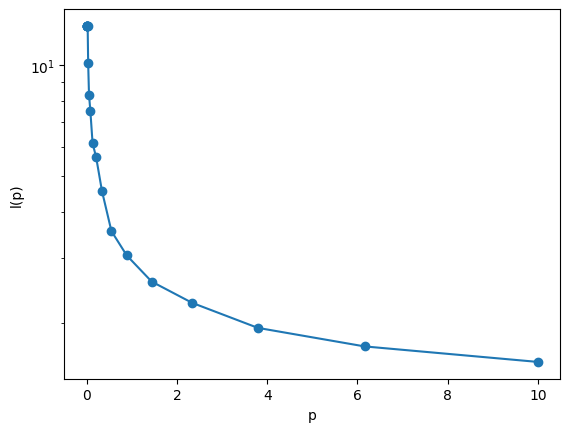

In [30]:
plt.plot(p_list,l_list,"-o")
plt.xlabel("p")
plt.ylabel("l(p)")
plt.yscale('log')
plt.xscale('linear')
plt.show()

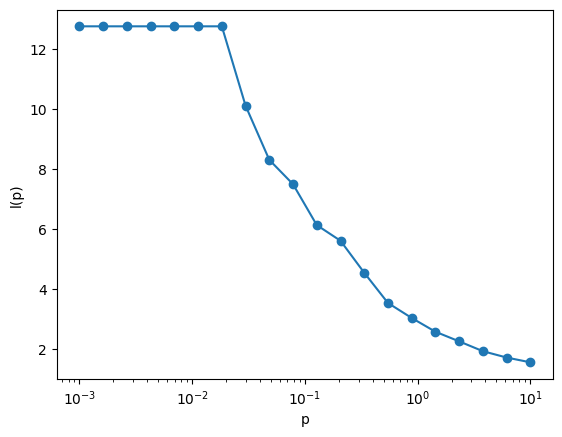

In [31]:
plt.plot(p_list,l_list,"-o")
plt.xlabel("p")
plt.ylabel("l(p)")
plt.yscale('linear')
plt.xscale('log')
plt.show()

In [32]:
lp0 = FindAveragePathLength(network.from_algorithm(50,2,0))

create 0 connections


Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.62it/s]


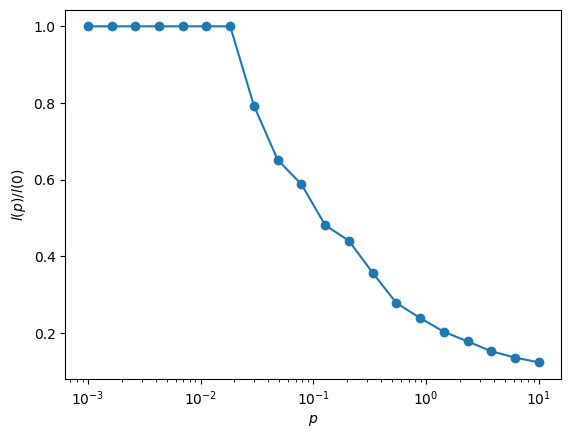

In [33]:
plt.plot(p_list,l_list/lp0,"-o")
plt.xlabel("$p$")
plt.ylabel("$l(p)/l(0)$")
plt.yscale('linear')
plt.xscale('log')
plt.show()

Create and display a circle graph of your geometry from part 4
(Z = 2, L = 50) at p = 0.1; create and display circle graphs of
Watts and Strogatz’s geometry (Z = 10, L = 1, 000) at p = 0.1 and
p = 0.001.

create 5 connections


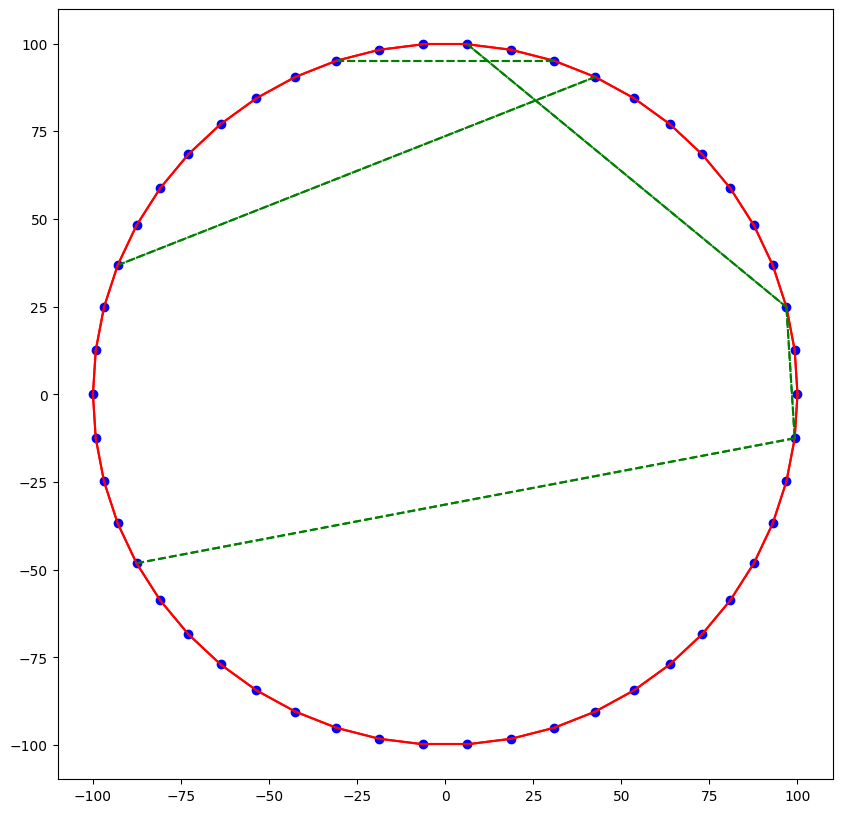

Compute: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.55it/s]


(array([214., 231., 244., 198., 192.,  80.,  48.,  18.]),
 array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  , 12.25, 14.5 , 16.75, 19.  ]),
 <BarContainer object of 8 artists>)

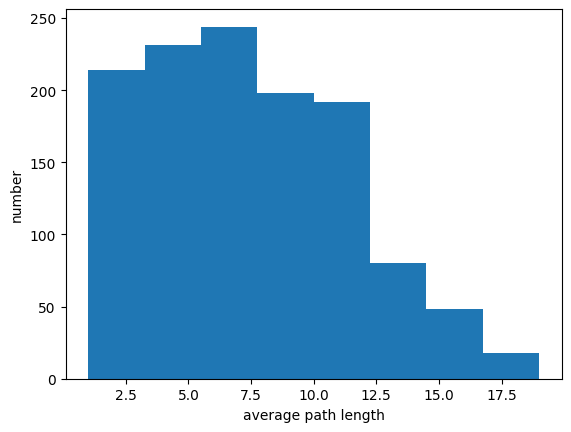

In [104]:
ntwrk_watts_strogatz_0 = network.from_algorithm(50,2,0.1)
ntwrk_watts_strogatz_0.draw_network(draw_text = False)

plt.xlabel("average path length")
plt.ylabel("number")
plt.hist(FindAllPathLengths(ntwrk_watts_strogatz_0),bins =8)

create 500 connections


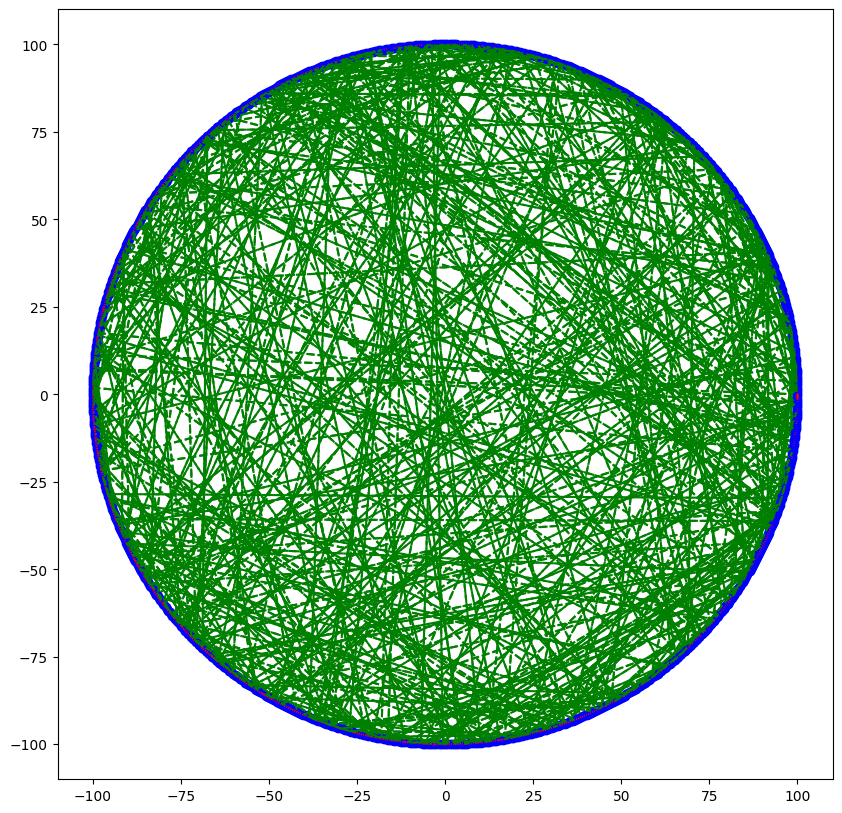

Compute: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.37it/s]


(array([4.97500e+03, 2.66080e+04, 3.94570e+04, 1.86626e+05, 1.97147e+05,
        3.35190e+04, 1.09890e+04, 1.79000e+02]),
 array([ 1.   ,  2.625,  4.25 ,  5.875,  7.5  ,  9.125, 10.75 , 12.375,
        14.   ]),
 <BarContainer object of 8 artists>)

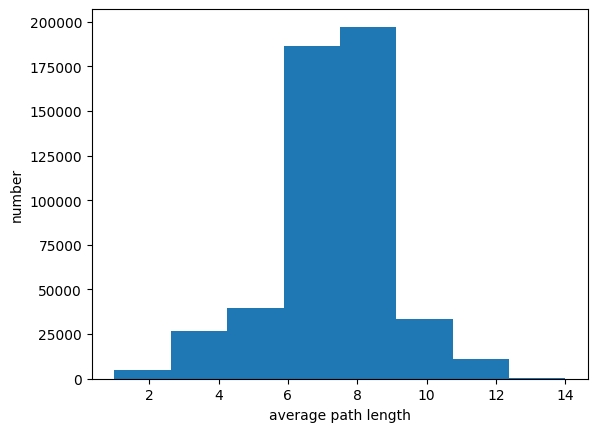

In [106]:
ntwrk_watts_strogatz_1 = network.from_algorithm(1000,2,0.5)
ntwrk_watts_strogatz_1.draw_network(draw_text = False)

plt.xlabel("average path length")
plt.ylabel("number")
plt.hist(FindAllPathLengths(ntwrk_watts_strogatz_1),bins=8)

create 5 connections


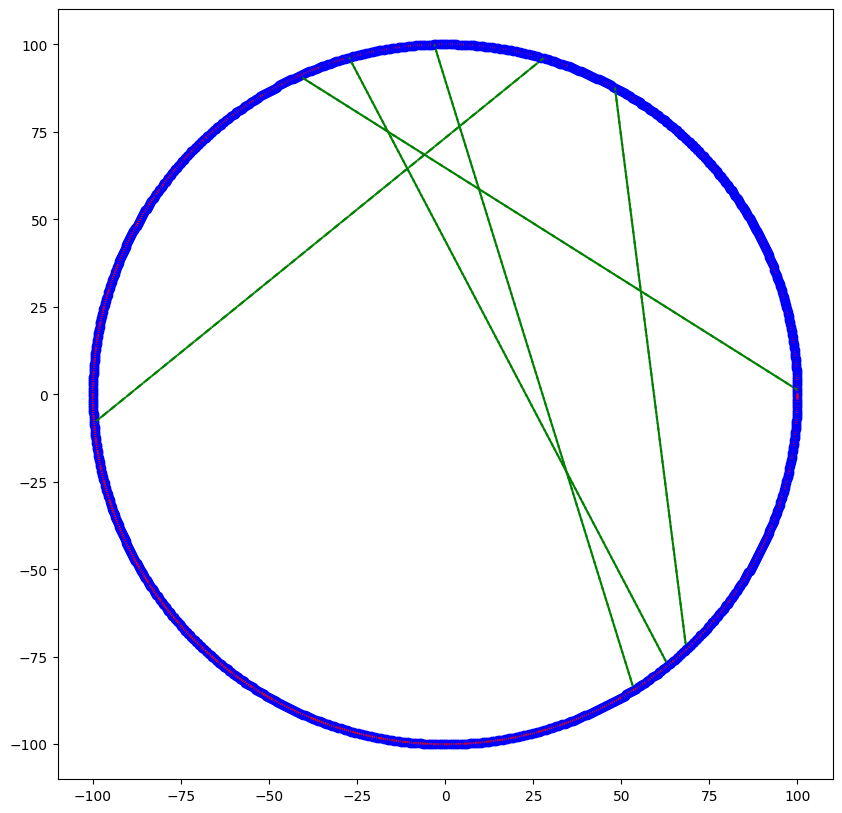

Compute: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.75it/s]


(array([37840., 60626., 82609., 86035., 81222., 59893., 44012., 25425.,
        16037.,  5801.]),
 array([  1. ,  29.7,  58.4,  87.1, 115.8, 144.5, 173.2, 201.9, 230.6,
        259.3, 288. ]),
 <BarContainer object of 10 artists>)

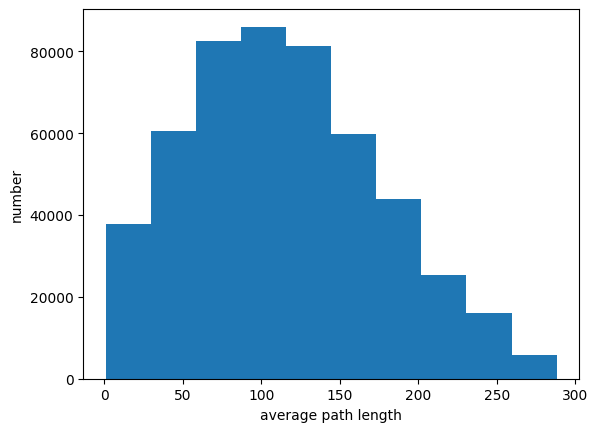

In [103]:
ntwrk_watts_strogatz_2 = network.from_algorithm(1000,2,0.005)
ntwrk_watts_strogatz_2.draw_network(draw_text = False)

plt.xlabel("average path length")
plt.ylabel("number")
fap = FindAllPathLengths(ntwrk_watts_strogatz_2)
plt.hist(fap)

 Plot the rescaled average path length pZL/l versus the
total number of shortcuts pLZ/2, for a range 0.001 < p < 1, for
L = 100 and L = 200, and for Z = 2 and Z = 4. In this limit, the
average bond length hqi should be a function only of M.

In [66]:
def plot_rapl(L,Z):
    rescaled_avg_path_lengths = []
    total_number_shortcuts = []

    for p in np.linspace(0.001,1,num=30):
        l = FindAveragePathLength(network.from_algorithm(L,Z,p))
        rescaled_avg_path_lengths.append(np.pi*Z*l/L)
        total_number_shortcuts.append(int(p*L*Z/2))

    plt.plot(total_number_shortcuts,rescaled_avg_path_lengths,"-o",label="")
    
    plt.ylabel("rescaled average path length pi*Z*L/l")
    plt.xlabel("total number shortcuts $p*L*Z/2$")


    return rescaled_avg_path_lengths, total_number_shortcuts


create 0 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.21it/s]


create 3 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.44it/s]


create 6 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.83it/s]


create 10 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 94.25it/s]


create 13 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.82it/s]


create 17 connections


Compute: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 109.30it/s]


create 20 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 98.03it/s]


create 24 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.03it/s]


create 27 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 92.68it/s]


create 31 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.42it/s]


create 34 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 92.04it/s]


create 37 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.32it/s]


create 41 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.18it/s]


create 44 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.77it/s]


create 48 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.21it/s]


create 51 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.55it/s]


create 55 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.97it/s]


create 58 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.66it/s]


create 62 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.14it/s]


create 65 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.03it/s]


create 68 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 94.07it/s]


create 72 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.80it/s]


create 75 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.15it/s]


create 79 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.46it/s]


create 82 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.58it/s]


create 86 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.95it/s]


create 89 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.86it/s]


create 93 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.24it/s]


create 96 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.50it/s]


create 100 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.84it/s]


create 0 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.18it/s]


create 7 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 54.73it/s]


create 13 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.70it/s]


create 20 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 55.74it/s]


create 27 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.33it/s]


create 34 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 39.52it/s]


create 41 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.94it/s]


create 48 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 36.66it/s]


create 55 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.45it/s]


create 62 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.60it/s]


create 69 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 39.48it/s]


create 75 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 45.22it/s]


create 82 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.60it/s]


create 89 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.10it/s]


create 96 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.14it/s]


create 103 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.81it/s]


create 110 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.98it/s]


create 117 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.74it/s]


create 124 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.75it/s]


create 131 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.11it/s]


create 137 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 36.36it/s]


create 144 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.06it/s]


create 151 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.19it/s]


create 158 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 39.68it/s]


create 165 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.31it/s]


create 172 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.72it/s]


create 179 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.57it/s]


create 186 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 37.51it/s]


create 193 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.60it/s]


create 200 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.87it/s]


create 0 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.17it/s]


create 7 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.61it/s]


create 13 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.15it/s]


create 20 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.27it/s]


create 27 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.84it/s]


create 34 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.48it/s]


create 41 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.54it/s]


create 48 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.16it/s]


create 55 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.77it/s]


create 62 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.23it/s]


create 69 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.25it/s]


create 75 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.20it/s]


create 82 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.78it/s]


create 89 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.57it/s]


create 96 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.70it/s]


create 103 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.27it/s]


create 110 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.84it/s]


create 117 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.28it/s]


create 124 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.15it/s]


create 131 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.75it/s]


create 137 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.55it/s]


create 144 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.18it/s]


create 151 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.11it/s]


create 158 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.34it/s]


create 165 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.80it/s]


create 172 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.20it/s]


create 179 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.14it/s]


create 186 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.07it/s]


create 193 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.19it/s]


create 200 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.90it/s]


create 0 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [05:12<00:00,  1.56s/it]


create 14 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:21<00:00,  9.12it/s]


create 27 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.72it/s]


create 41 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.37it/s]


create 55 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.24it/s]


create 69 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.12it/s]


create 83 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.47it/s]


create 96 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.39it/s]


create 110 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.04it/s]


create 124 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.18it/s]


create 138 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.26it/s]


create 151 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.32it/s]


create 165 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.54it/s]


create 179 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.15it/s]


create 193 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.74it/s]


create 207 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.97it/s]


create 220 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.53it/s]


create 234 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.97it/s]


create 248 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.03it/s]


create 262 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.27it/s]


create 275 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.29it/s]


create 289 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.69it/s]


create 303 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.13it/s]


create 317 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.04it/s]


create 331 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.62it/s]


create 344 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.03it/s]


create 358 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.54it/s]


create 372 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.54it/s]


create 386 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.84it/s]


create 400 connections


Compute: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.35it/s]


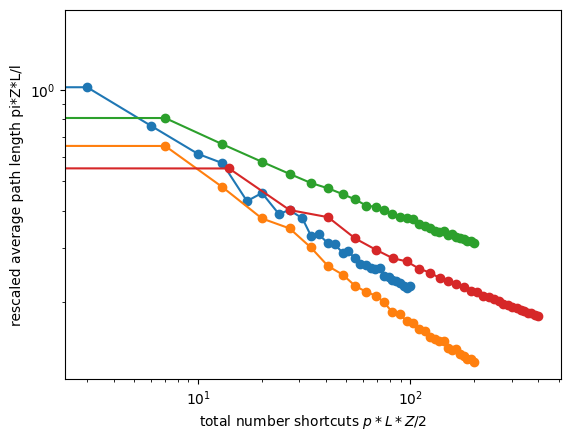

In [67]:
rapl1, tns1 = plot_rapl(100,2)
rapl2, tns2 = plot_rapl(200,2)
rapl3, tns3 = plot_rapl(100,4)
rapl4, tns4 = plot_rapl(200,4)

plt.yscale('log')
plt.xscale('log')
plt.show()

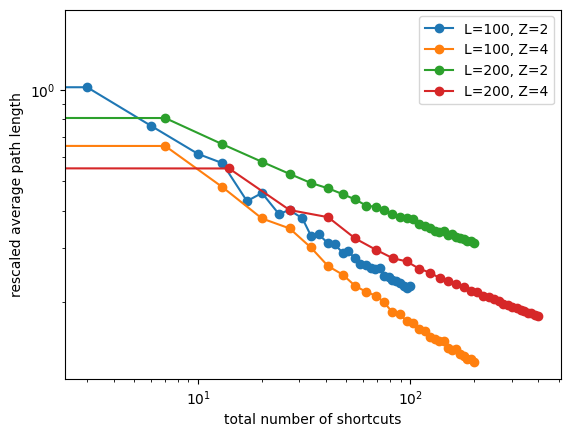

In [85]:
plt.plot(tns1,rapl1,"-o",label="L=100, Z=2")
plt.plot(tns2,rapl2,"-o",label="L=100, Z=4")
plt.plot(tns3,rapl3,"-o",label="L=200, Z=2")
plt.plot(tns4,rapl4,"-o",label="L=200, Z=4")


plt.yscale('log')
plt.xscale('log')
plt.xlabel("total number of shortcuts")
plt.ylabel("rescaled average path length")
plt.legend()

plt.show()

## Real_world

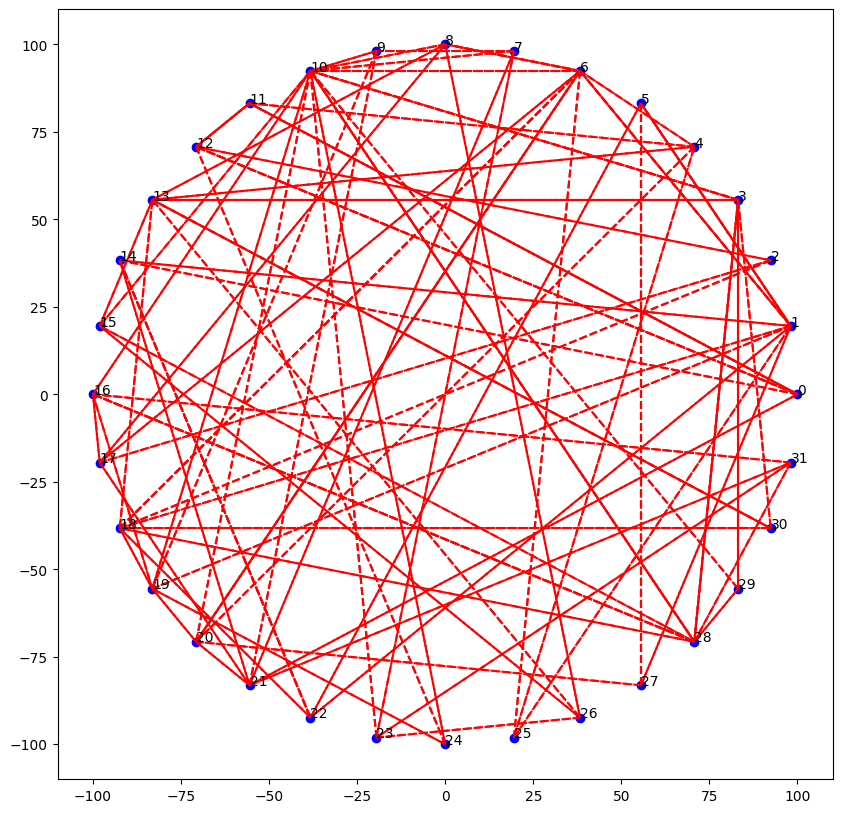

In [138]:
path = r'C:\Users\Sönke Beier\Desktop\Uni-Daten\Master\Computational Physics\six_degrees_of_seperation\leader.csv'
real_ntwrk = network.from_real_world(path)

real_ntwrk.draw_network(draw_text=True)

In [139]:
list_real = FindAllPathLengths(real_ntwrk)

Compute: 100%|████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 136.35it/s]


Text(0, 0.5, 'number')

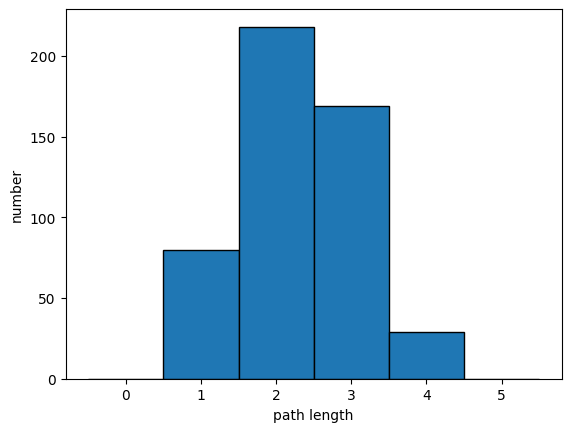

In [147]:
bin_edges = np.arange( - 0.5, max(list_real) + 2.5, 1)  # Bin edges centered around integers
hist_real = plt.hist(list_real, bins=bin_edges, edgecolor='black')

plt.xlabel("path length")
plt.ylabel("number")

In [142]:
FindAveragePathLength(real_ntwrk)

Compute: 100%|████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 140.14it/s]


2.2963709677419355

In [143]:
import networkx as nx

C:\Users\Sönke Beier\AppData\Local\Temp\ipykernel_19800\628506170.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


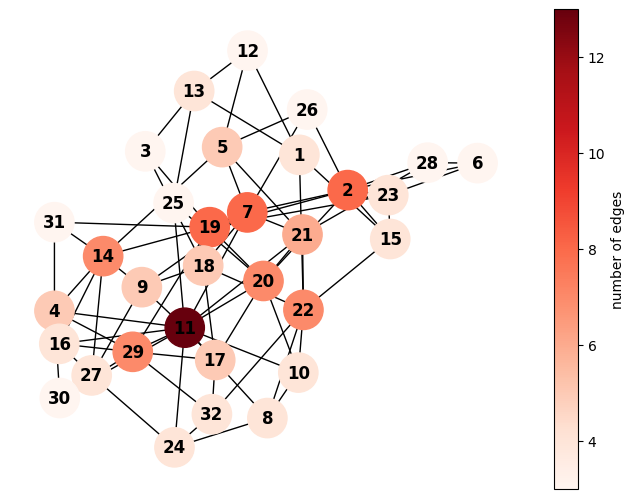

In [144]:
#Created with Chatgpt:

# Create an empty graph
G = nx.Graph()

# Read data from the text file and add edges to the graph
with open(r'C:\Users\Sönke Beier\Desktop\Uni-Daten\Master\Computational Physics\six_degrees_of_seperation\leader.csv') as file:
    for line in file:
        nodes = line.split()
        nodes = nodes[0:2]
        if len(nodes) == 2:
            node1, node2 = map(int, nodes)
            G.add_edge(node1, node2)

# Calculate node colors based on the number of edges
node_colors = [G.degree(node) for node in G.nodes()]

# Draw the graph with variable node colors
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, cmap=plt.cm.Reds, node_size=800)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin = min(node_colors), vmax=max(node_colors)))
sm._A = []
cbar = plt.colorbar(sm)
cbar.set_label('number of edges')

# Display the graph
plt.show()